In [1]:
import pandas as pd
import numpy as np
import cv2 as cv
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import scatter_matrix
import itertools
from sklearn.preprocessing import LabelEncoder
from IPython.display import display
import seaborn as sns
import xgboost as xgb
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from matplotlib.pylab import rcParams
from sklearn.tree import DecisionTreeRegressor

1. Wczytanie zbioru danych

In [2]:
data= pd.read_csv("Car_Prices_Poland_Kaggle.csv")
print(data.info())
print(data.shape)
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117927 entries, 0 to 117926
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Unnamed: 0       117927 non-null  int64 
 1   mark             117927 non-null  object
 2   model            117927 non-null  object
 3   generation_name  87842 non-null   object
 4   year             117927 non-null  int64 
 5   mileage          117927 non-null  int64 
 6   vol_engine       117927 non-null  int64 
 7   fuel             117927 non-null  object
 8   city             117927 non-null  object
 9   province         117927 non-null  object
 10  price            117927 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 9.9+ MB
None
(117927, 11)


,Unnamed: 0,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
0,0,opel,combo,gen-d-2011,2015,139568,1248,Diesel,Janki,Mazowieckie,35900
1,1,opel,combo,gen-d-2011,2018,31991,1499,Diesel,Katowice,Śląskie,78501
2,2,opel,combo,gen-d-2011,2015,278437,1598,Diesel,Brzeg,Opolskie,27000
3,3,opel,combo,gen-d-2011,2016,47600,1248,Diesel,Korfantów,Opolskie,30800
4,4,opel,combo,gen-d-2011,2014,103000,1400,CNG,Tarnowskie Góry,Śląskie,35900


2. Analiza i czyszczenie zbioru danych

In [3]:

m1 = data['province'] == 'Moravian-Silesian Region'
m2 = data['province'] == 'Berlin'
m3 = data['province'] == 'Wiedeń'
m4 = data['province'] == 'Trenczyn'
m5 = data['province'] == 'Niedersachsen'
m6 = data['province'] == 'Nordrhein-Westfalen'
m7 = data['province'] == '('
m8 = data['fuel'] == 'CNG'
m9 = data['year'] < 1992
m10 = data['vol_engine'] == 1
data.loc[data['fuel'] == 'Electric', 'vol_engine'] = 1
m11 = data['vol_engine'] <= 0
mo=[m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11]
for m in mo:
    data = data.drop(data.loc[m].index)
data['province'].value_counts()
#data.loc[data['fuel'] == 'Electric', 'vol_engine'] = 1

Mazowieckie            22091
Śląskie                16616
Wielkopolskie          13910
Małopolskie             9730
Dolnośląskie            8757
Łódzkie                 7876
Pomorskie               7589
Kujawsko-pomorskie      5364
Lubelskie               4730
Zachodniopomorskie      3955
Podkarpackie            3534
Świętokrzyskie          3321
Warmińsko-mazurskie     2952
Lubuskie                2737
Podlaskie               2119
Opolskie                2064
Name: province, dtype: int64

In [4]:
counts = data['model'].value_counts()
mod=data['model'].isin(counts[counts < 60].index)
data = data.drop(data.loc[mod].index)

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
z=data.where(data["mark"] == 'volkswagen').sort_values(by="vol_engine").dropna()
display(z)

In [6]:
def f1():
    data['Marka'] = data['mark']
    data['Model'] = data['model']
    data['Silnik'] = data['fuel']
    data['Wojewodztwo'] = data['province']
    label=LabelEncoder()
    data["mark"]=label.fit_transform(data["mark"])
    data["model"]=label.fit_transform(data["model"])
    data["fuel"]=label.fit_transform(data["fuel"])
    data["province"]=label.fit_transform(data["province"])
    data['mark']=data['mark']+1
    data['model']=data['model']+1
    data.head()
f1()


In [7]:
data["Silnik"] = data["Silnik"].replace({"Gybryda": "Hybryda", "elektryczny": "Elektryczny","Gasoline": "Benzyna"})
data['Silnik'].unique()

array(['Diesel', 'Benzyna', 'LPG', 'Electric', 'Hybrid'], dtype=object)

In [8]:
df=data
data.head()

,Unnamed: 0,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price,Marka,Model,Silnik,Wojewodztwo
0,0,16,83,gen-d-2011,2015,139568,1248,0,Janki,4,35900,opel,combo,Diesel,Mazowieckie
1,1,16,83,gen-d-2011,2018,31991,1499,0,Katowice,14,78501,opel,combo,Diesel,Śląskie
2,2,16,83,gen-d-2011,2015,278437,1598,0,Brzeg,6,27000,opel,combo,Diesel,Opolskie
3,3,16,83,gen-d-2011,2016,47600,1248,0,Korfantów,6,30800,opel,combo,Diesel,Opolskie
5,5,16,83,gen-d-2011,2017,121203,1598,0,Warszawa,4,51900,opel,combo,Diesel,Mazowieckie


In [9]:

model=data[['mark','Marka','model','Model']]
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
model=model.sort_values(by='model').drop_duplicates()
model.to_csv('model_data2.txt', sep='\t', index=False)



3. Wykresy

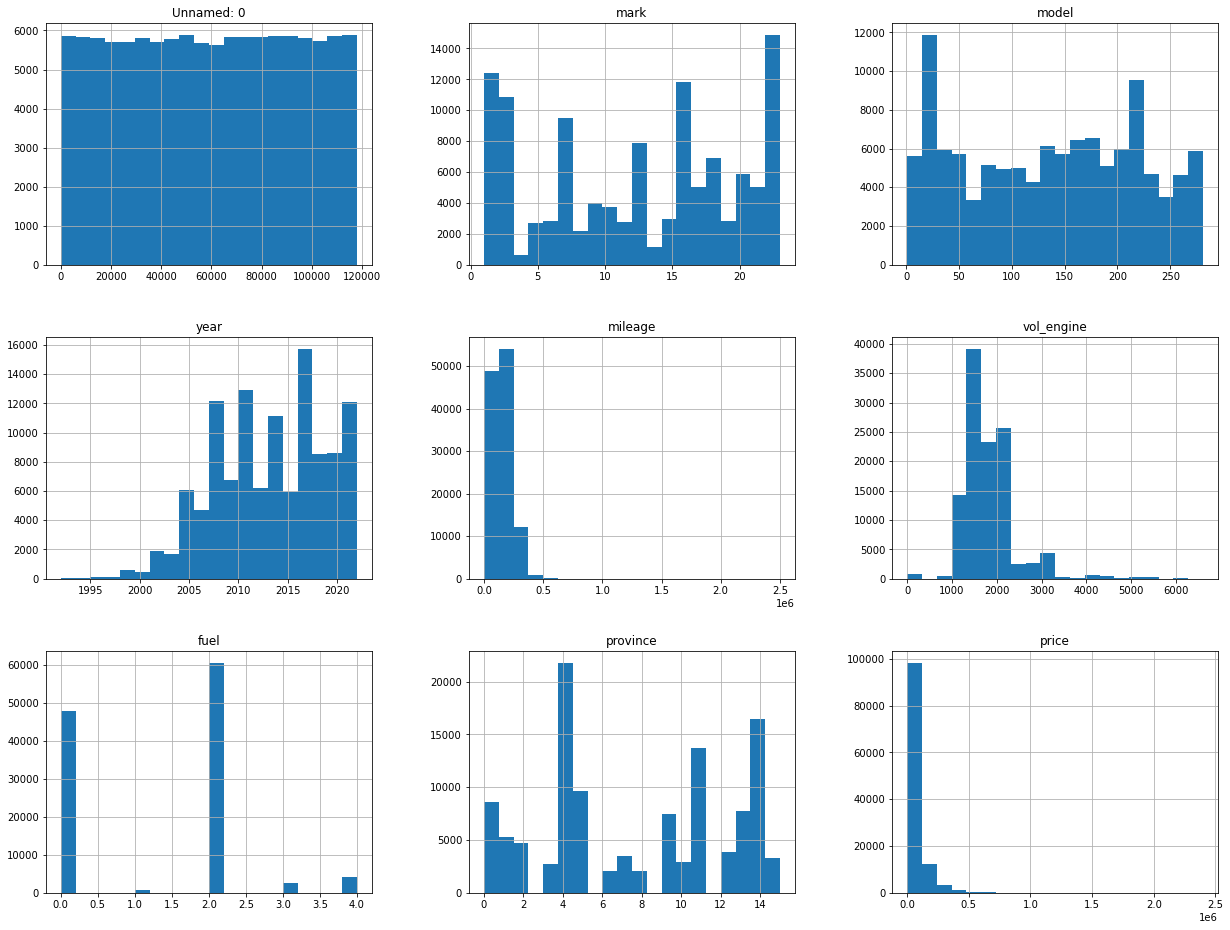

In [31]:
df.hist(bins=20, figsize=(21,16))
plt.show()

In [ ]:
#df["mileage_cat"] = pd.cut(df["mileage"],
            #               bins=[0., 50000, 100000, 150000, 200000, 3000000],
                     #      labels=[1, 2, 3, 4, 5])

c:\Users\patry\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


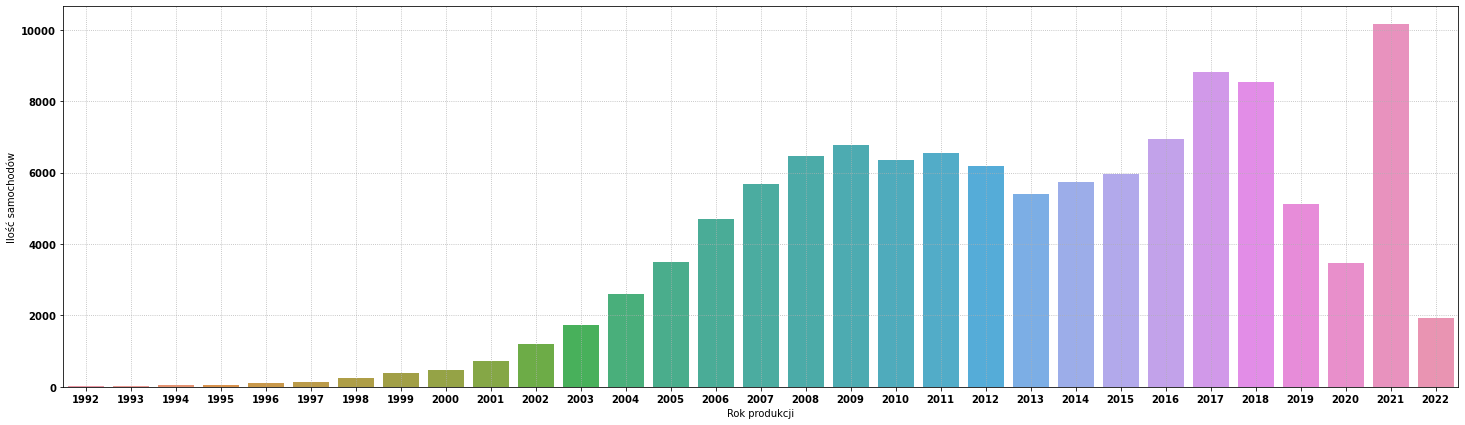

In [36]:
def w1():    
    plt.figure(figsize=(25,7))
    #plt.title("Ilość samochodów z podziałem na rok produkcj zbiorze danych")
    plt.setp(plt.gca().get_xticklabels(), weight='bold')
    plt.setp(plt.gca().get_yticklabels(), weight='bold')
    sns.countplot(df['Rok produkcji'])
    plt.ylabel("Ilość samochodów")
    plt.grid(linestyle="dotted")
    plt.show()
w1()

c:\Users\patry\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


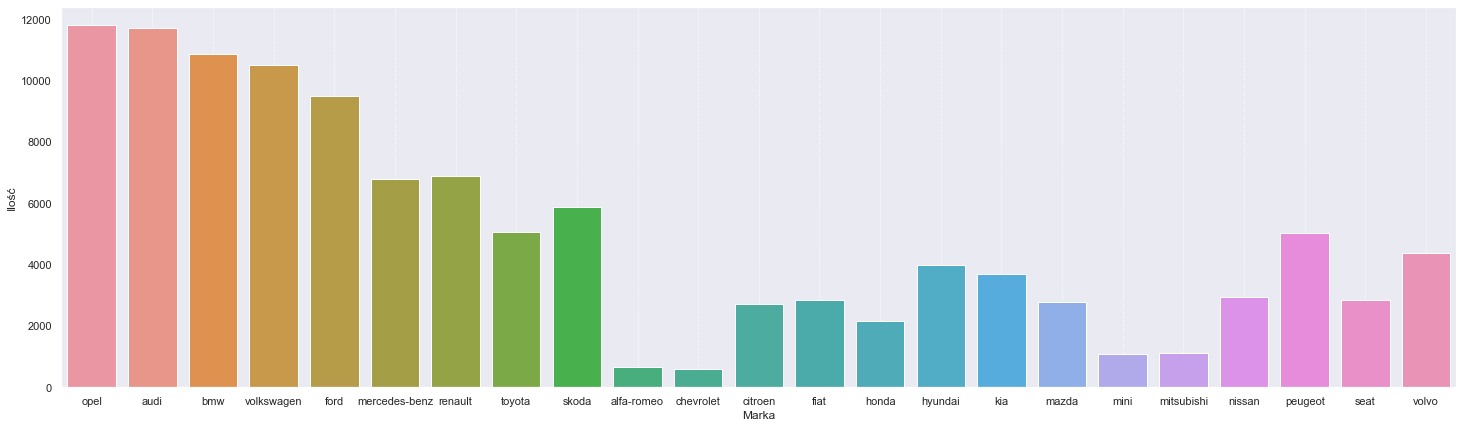

In [116]:
def w2():
    plt.figure(figsize=(25,7))
    plt.setp(plt.gca().get_xticklabels(), weight='bold')
    plt.setp(plt.gca().get_yticklabels(), weight='bold')
    sns.countplot(df['Marka'])
    plt.ylabel("Ilość")
    plt.grid(linestyle="dotted")
    plt.show()
w2()

c:\Users\patry\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


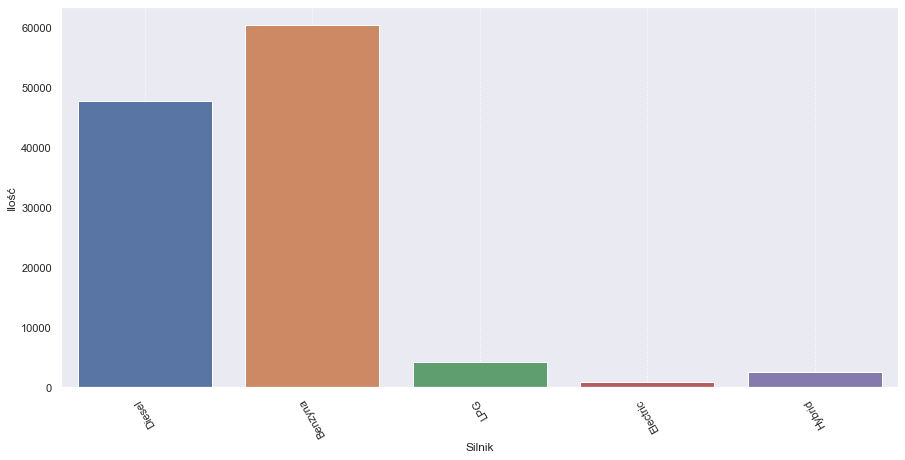

In [165]:
def w3():
    plt.figure(figsize=(15,7))

    sns.countplot(df["Silnik"])
    plt.ylabel("Ilość")
    plt.xticks(rotation=120)
    plt.grid(linestyle="dotted")
    plt.show()
w3()

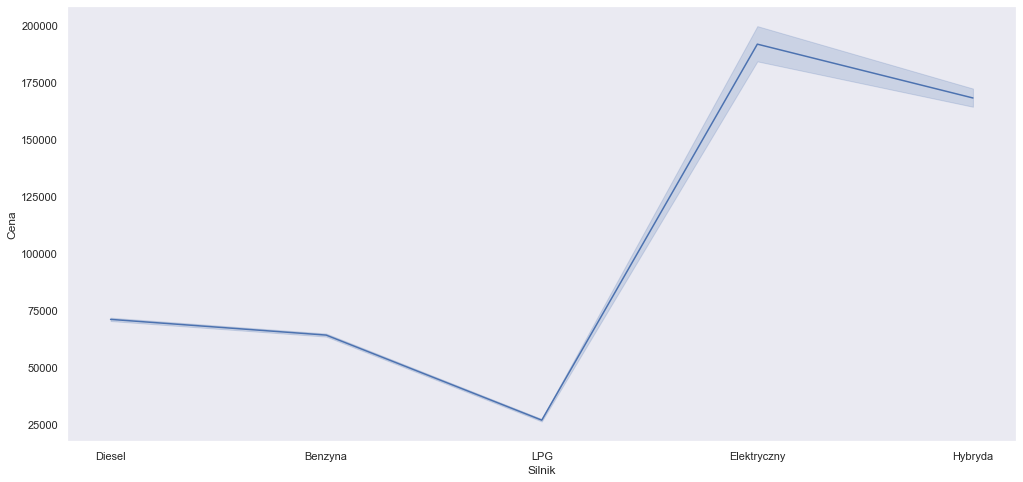

In [126]:
def w4():
    plt.figure(figsize=(17,8))

    sns.lineplot(data=df,x="Silnik",y="price")
    plt.ylabel("Cena")
    plt.grid(linestyle="dotted")
    plt.show()
w4()


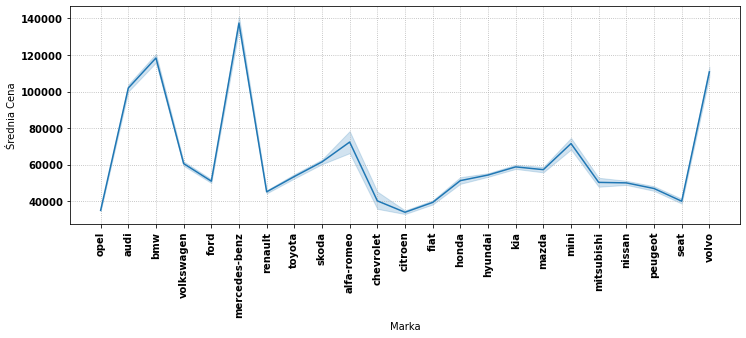

In [20]:
def w4():
    plt.figure(figsize=(12,4))

    sns.lineplot(data=df,x="Marka",y="price")
    plt.xticks(rotation=90)
    plt.ylabel("Średnia Cena")
    plt.grid(linestyle="dotted")
    plt.setp(plt.gca().get_xticklabels(), weight='bold')
    plt.setp(plt.gca().get_yticklabels(), weight='bold')
    plt.show()
w4()



In [67]:
data.columns

Index(['Unnamed: 0', 'mark', 'model', 'generation_name', 'year', 'mileage',
       'vol_engine', 'fuel', 'city', 'province', 'price', 'Marka', 'Model',
       'Silnik', 'Wojewodztwo'],
      dtype='object')

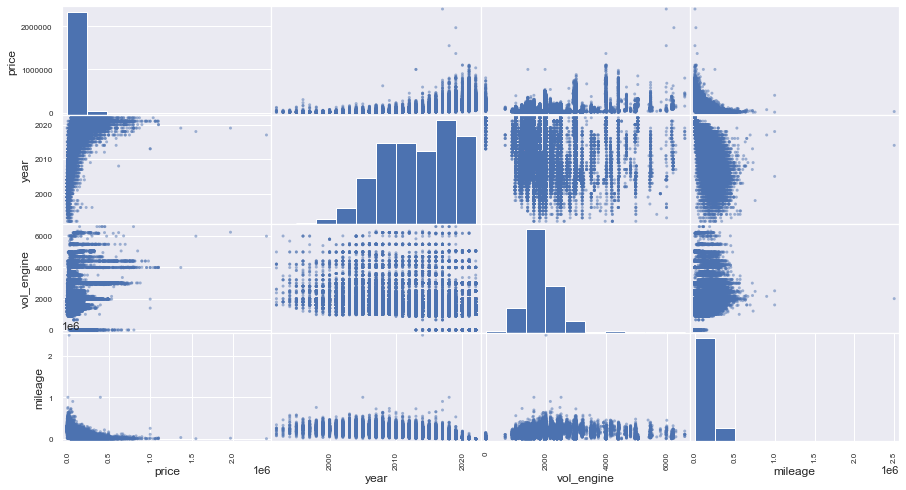

In [129]:
att = ["price", "year", "vol_engine", "mileage"]
scatter_matrix(df[att], figsize=(15, 8));

In [10]:
def f2():
    data.drop(columns=["Unnamed: 0"],axis=1 ,inplace=True)
    data.drop(columns=["generation_name"],axis=1 ,inplace=True)
    data.drop(columns=["city"],axis=1 ,inplace=True)
    data.drop(columns=["Marka"],axis=1 ,inplace=True)
    data.drop(columns=["Model"],axis=1 ,inplace=True)
    data.drop(columns=["Silnik"],axis=1 ,inplace=True)
    data.drop(columns=["Wojewodztwo"],axis=1 ,inplace=True)
  #  data.drop(columns=["mileage_cat"],axis=1 ,inplace=True)
  #  data.drop(columns=["Rok produkcji"],axis=1 ,inplace=True)
f2()

In [38]:
data.describe().round(1)
desc=data[['year','mileage','vol_engine','price']]
desc.describe().round(1)

,year,mileage,vol_engine,price
count,115877.0,115877.0,115877.0,115877.0
mean,2012.9,141432.4,1808.0,68973.1
std,5.5,91595.4,619.0,82084.3
min,1992.0,0.0,1.0,500.0
25%,2009.0,68168.0,1461.0,21000.0
50%,2013.0,147000.0,1796.0,41700.0
75%,2018.0,203000.0,1995.0,82000.0
max,2022.0,2500000.0,6600.0,2399900.0


In [39]:
data.corr()

,mark,model,year,mileage,vol_engine,fuel,province,price
mark,1.000000,0.141548,0.033411,-0.031428,-0.262004,0.074171,0.003279,-0.147439
model,0.141548,1.000000,0.067677,-0.024986,0.110113,-0.060020,0.006417,0.144682
year,0.033411,0.067677,1.000000,-0.749573,-0.147026,-0.029821,0.036809,0.613763
mileage,-0.031428,-0.024986,-0.749573,1.000000,0.207675,-0.247627,-0.052637,-0.546602
vol_engine,-0.262004,0.110113,-0.147026,0.207675,1.000000,-0.167841,-0.034080,0.313946
fuel,0.074171,-0.060020,-0.029821,-0.247627,-0.167841,1.000000,0.012381,-0.038114
province,0.003279,0.006417,0.036809,-0.052637,-0.034080,0.012381,1.000000,0.030469
price,-0.147439,0.144682,0.613763,-0.546602,0.313946,-0.038114,0.030469,1.000000


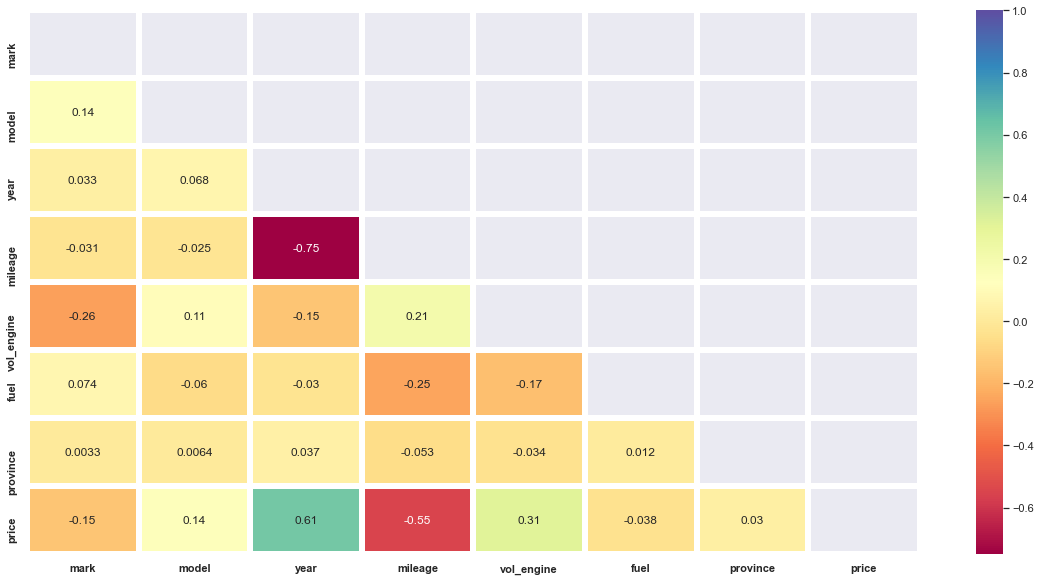

In [41]:
def corr():
    correlation_matrix = data.corr()
    sns.set(rc={'figure.figsize':(20,10)}) 
    mask = np.triu(np.ones_like(correlation_matrix), k=0) 
    sns.heatmap(correlation_matrix, annot=True, cmap = 'Spectral', linewidths=5, mask=mask, vmax=1)
    plt.setp(plt.gca().get_xticklabels(), weight='bold')
    plt.setp(plt.gca().get_yticklabels(), weight='bold')
    pass
corr()

In [12]:
data.head()

,mark,model,year,mileage,vol_engine,fuel,province,price
0,16,83,2015,139568,1248,0,4,35900
1,16,83,2018,31991,1499,0,14,78501
2,16,83,2015,278437,1598,0,6,27000
3,16,83,2016,47600,1248,0,6,30800
5,16,83,2017,121203,1598,0,4,51900


Uczenie maszynowe

1. LinearRegression()

In [13]:
X = data.drop(['price'], axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.9, random_state=42)
print(' Train : ', X_train.shape, y_train.shape,'\n', 'Test' , X_test.shape, y_test.shape)

 Train :  (104289, 7) (104289,) 
 Test (11588, 7) (11588,)


In [165]:
lnr = LinearRegression()

lnr.fit(X_train, y_train)

y_pred = lnr.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Miary skuteczności modelu LinearRegression() ')
print('RMSE: ', round(rmse,2) , '\nMAE: ', round(mae,2),'\nR^2: ', round(r2,4))

Miary skuteczności modelu LinearRegression() 
RMSE:  53588.94 
MAE:  32024.3 
R^2:  0.5808


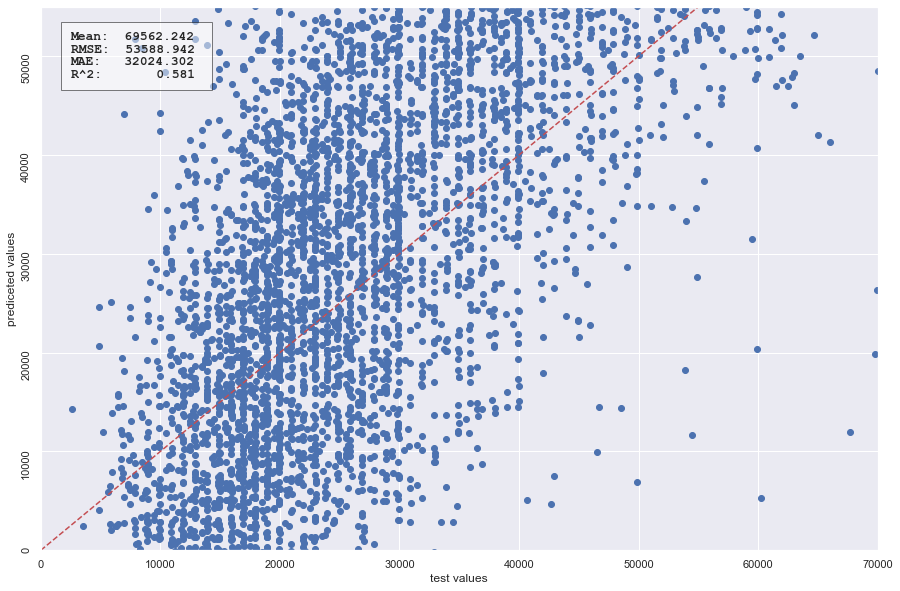

In [141]:
def w1():
       
        max = 55000

        sns.set(rc={'figure.figsize':(15,10)})
        plt.xlim(0,70000)
        plt.ylim(0,max)
        plt.scatter(y_test,y_pred)
        plt.yticks(rotation="90")
        plt.xlabel("test values")
        plt.ylabel("prediceted values")
        plt.plot([0,max],[0,max],'r--')

        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
                #plt.title(str(title).upper(), font={'size':16})
        t1, t2, t3, t4 = "Mean:", "RMSE:", "MAE:", "R^2:"
        s1, s2, s3, s4 = format(y_pred.mean(),'.3f'), format(rmse,'.3f'), format(mae,'.3f'), format(r2,'.3f')
        plt.annotate(f"{t1} {s1:>10} \n{t2} {s2:>10} \n{t3} {s3:>11} \n{t4} {s4:>11}", [2500,max*.87],
                                font={'size':13, 'family':'courier new', 'weight':'bold'},
                                bbox={'facecolor': 'white', 'edgecolor' : 'black', 'alpha': 0.5, 'pad': 10})
     
        plt.show()
w1()

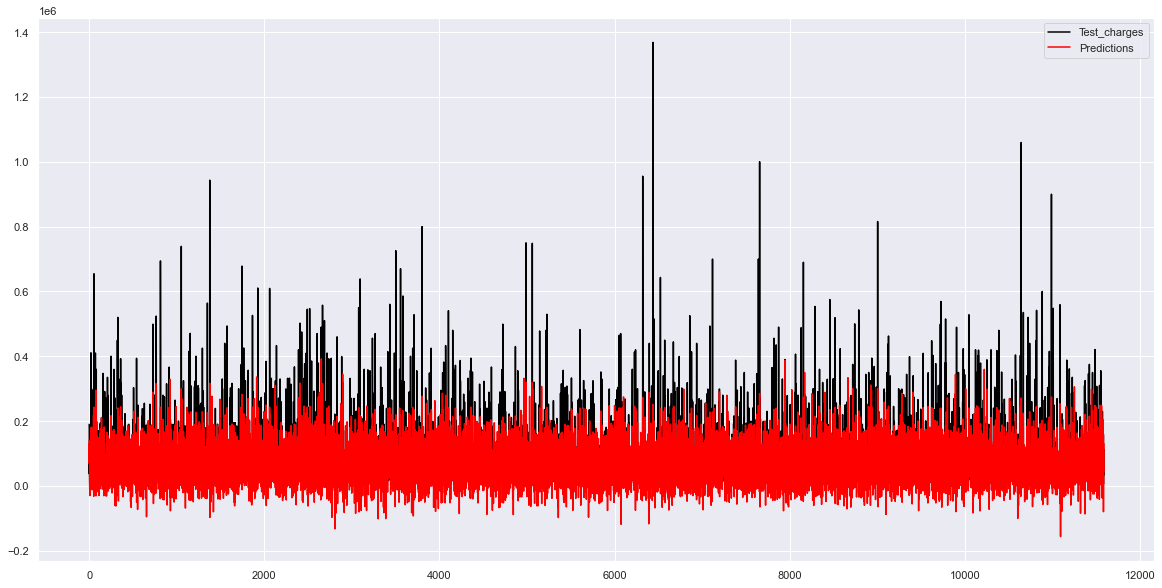

In [142]:
def pred_plot():
    plt.figure(figsize=(20,10))
    

    plt.plot(np.arange(len(y_test)), y_test, color='black', label='Test_charges')
    plt.plot(np.arange(len(y_pred)), y_pred, color='red' ,label='Predictions')
    plt.legend()

    plt.show()
pred_plot()

2. DecisionTreeRegressor

In [143]:

model_dtr=DecisionTreeRegressor()
model_dtr
model_dtr.fit(X_train,y_train)
y_pred=model_dtr.predict(X_test)
print("Wyniki medelu DecisionTreeRegressor() :")

rmse=np.sqrt(mean_squared_error(y_test,y_pred))
mae=mean_absolute_error(y_test,y_pred)
print('RMSE : ',rmse)
print('MAE', mae)
print('R^2 : ',model_dtr.score(X_test,y_test))

Wyniki medelu DecisionTreeRegressor() :
RMSE :  23708.605871496937
MAE 9952.437903904045
R^2 :  0.9179544177969029


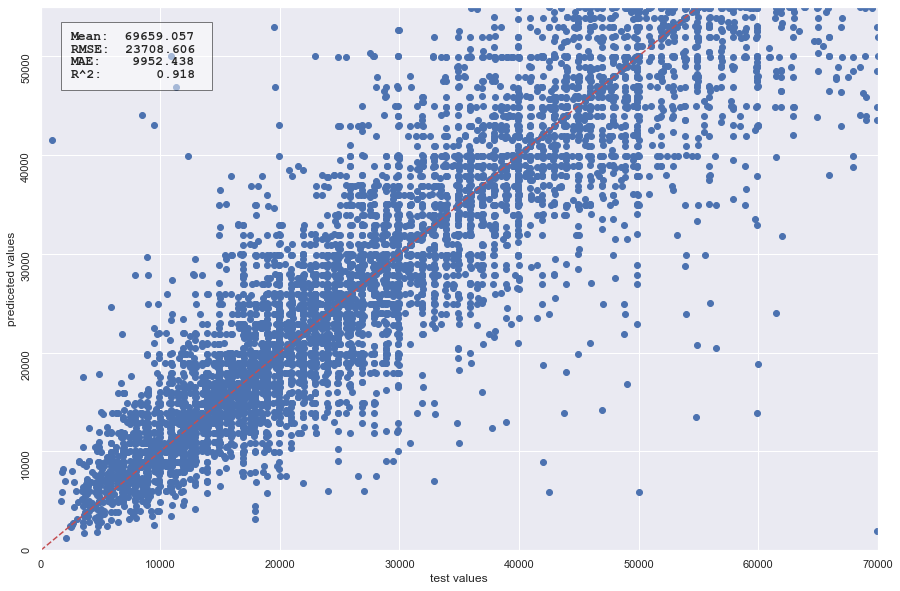

In [144]:
w1()

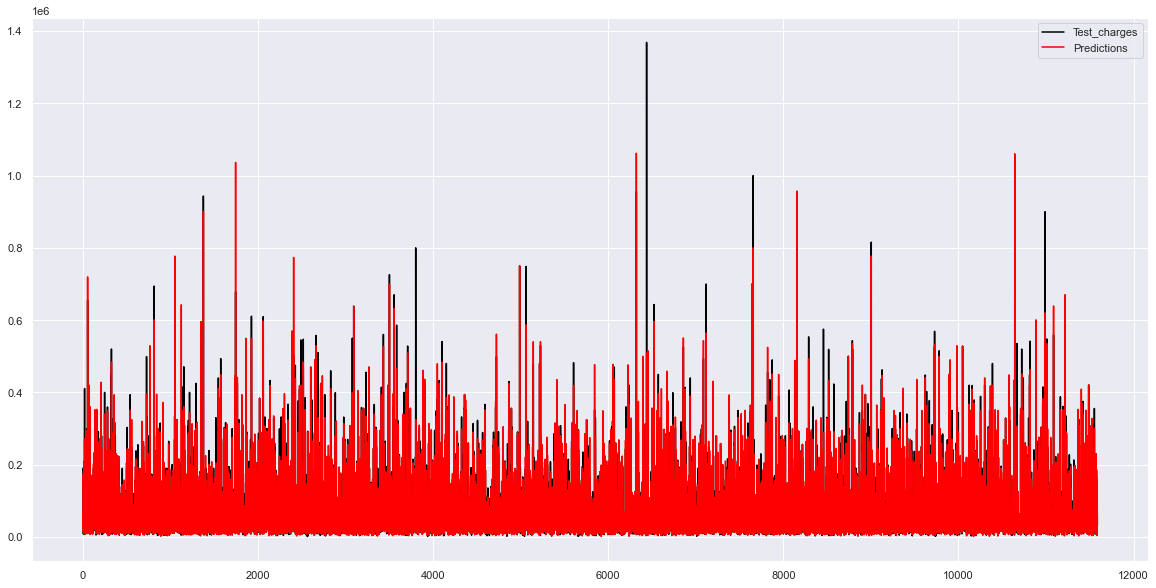

In [145]:
pred_plot()

3. RandomForestRegressor()

In [146]:
rfr=RandomForestRegressor()
rfr.fit(X_train,y_train)
y_pred=rfr.predict(X_test)
print("Wyniki medelu RandomForestRegressor() :")
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
mae=mean_absolute_error(y_test,y_pred)
print('RMSE : ',rmse)
print('MAE', mae)
print('R^2 : ',rfr.score(X_test,y_test))

Wyniki medelu RandomForestRegressor() :
RMSE :  19790.106565659036
MAE 8253.31549371814
R^2 :  0.9428337857535177


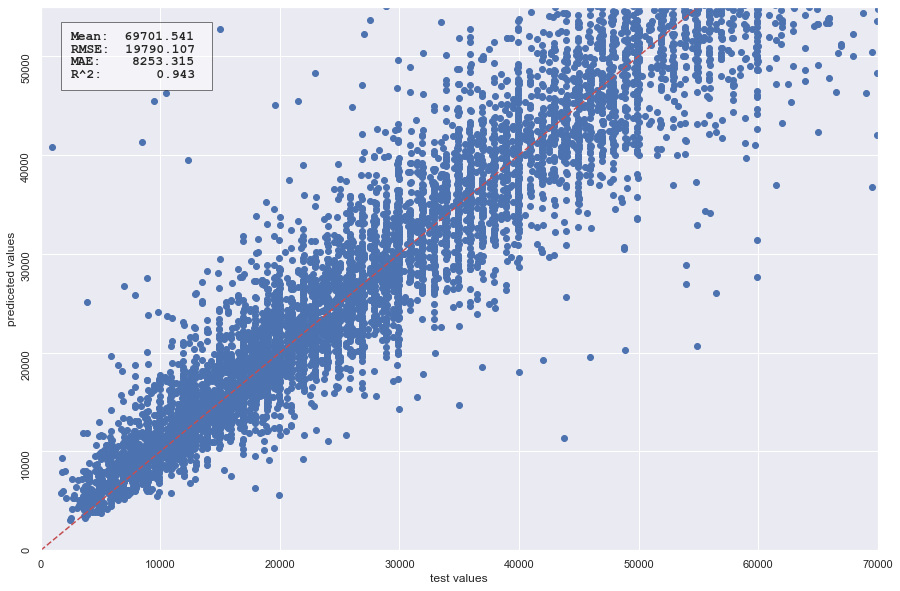

In [147]:
w1()

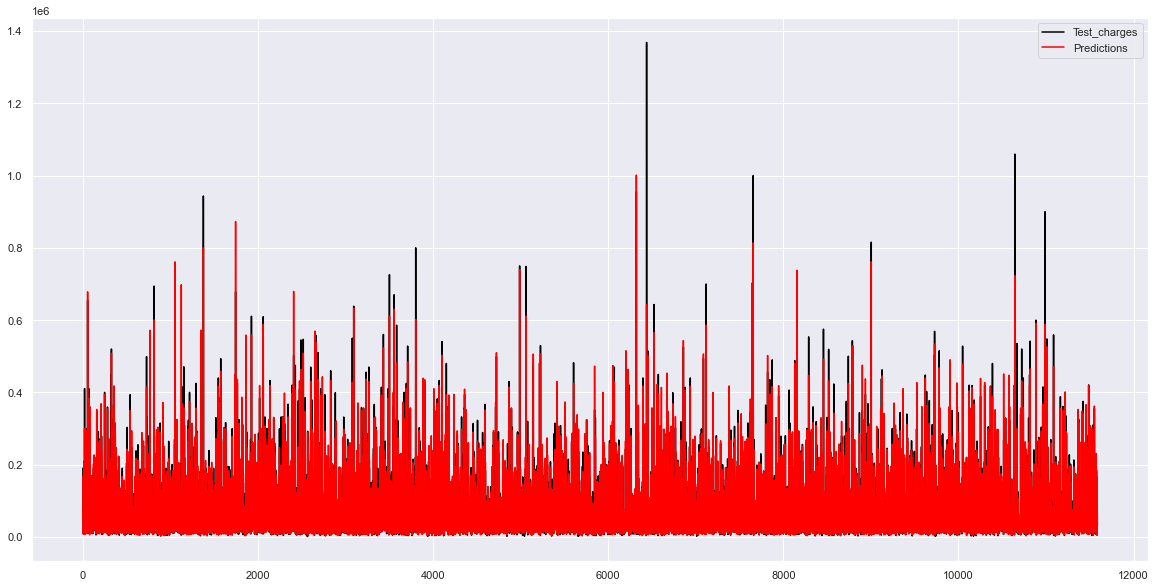

In [148]:
pred_plot()

Dobieranie najlepszych hiperparametrów dla RandomForestRegressor()

In [130]:
#RANDOMIZEDSEARCHCV 
params={
    
'n_estimators': [100, 200, 300, 400, 500],
'max_depth': [5, 10, 15, 20, 25, None],
'min_samples_split': [2, 5, 10, 15, 20],
'min_samples_leaf': [1, 2, 4, 6, 8],
'max_features': ['auto', 'sqrt', 'log2', None],

}
l7=[]
model_rfr=RandomForestRegressor()
random_search=RandomizedSearchCV(model_rfr, param_distributions=params)
random_search.fit(X_train, y_train)
y_pred=random_search.predict(X_test)
print('Score R2 : ',random_search.score(X_test,y_test))
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
mae=mean_absolute_error(y_test,y_pred)
print('RMSE : ',rmse)
print('MAE', mae)
print('best_params: ',random_search.best_params_)
print("================")
l7.append([ rmse,'MAE :', mae,'best_params: ',random_search.best_params_, 'params_estimator',random_search.best_estimator_] )


Score R2 :  0.9434934063226627
RMSE :  19675.59980138292
MAE 8239.761633295198
best_params:  {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}


In [132]:
random_search.best_params_

{'n_estimators': 300,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_depth': None}

4. XGBRegressor()

In [149]:
#model próbny bez hiperparametrów
model_x1=xgb.XGBRegressor()
model_x1
model_x1.fit(X_train,y_train)
y_pred=model_x1.predict(X_test)
print("wyniki medelu XGBRegressor() :")
print('Score R2 : ',model_x1.score(X_test,y_test))
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
mae=mean_absolute_error(y_test,y_pred)
print('RMSE : ',rmse)
print('MAE', mae)

wyniki medelu XGBRegressor() :
Score R2 :  0.9406667775497273
RMSE :  20161.710965077345
MAE 9265.408730222145


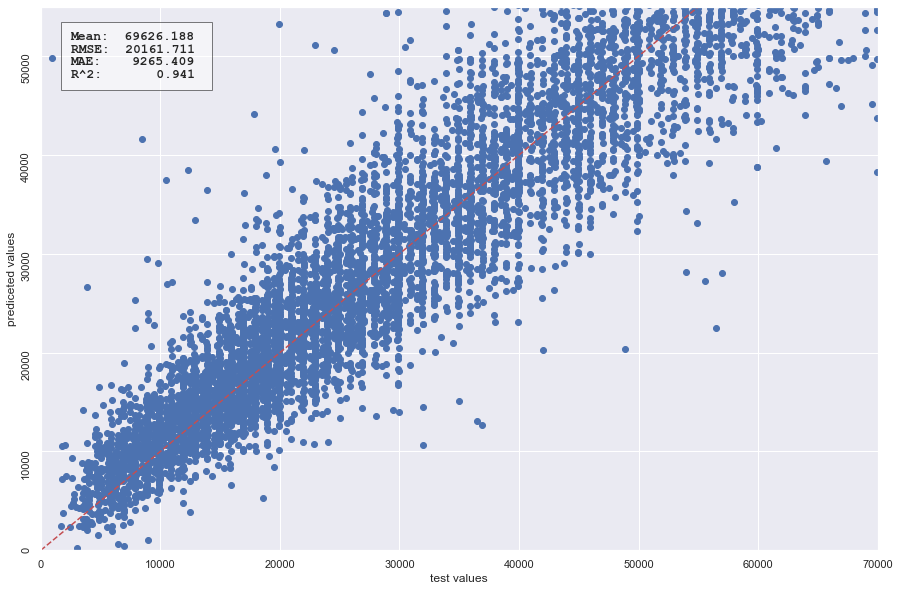

In [150]:
w1()

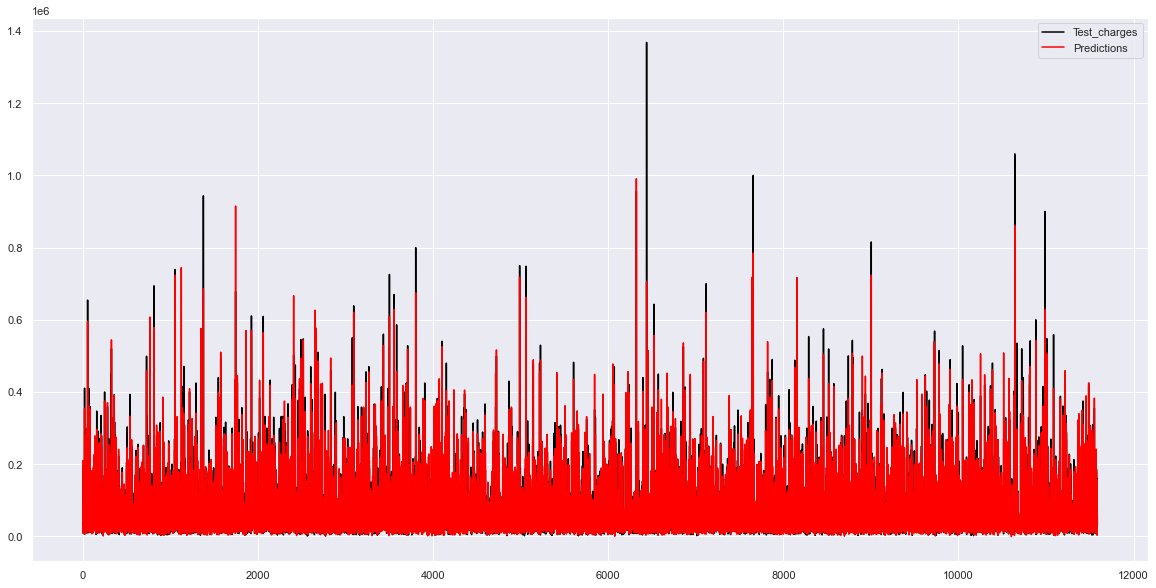

In [151]:

pred_plot()

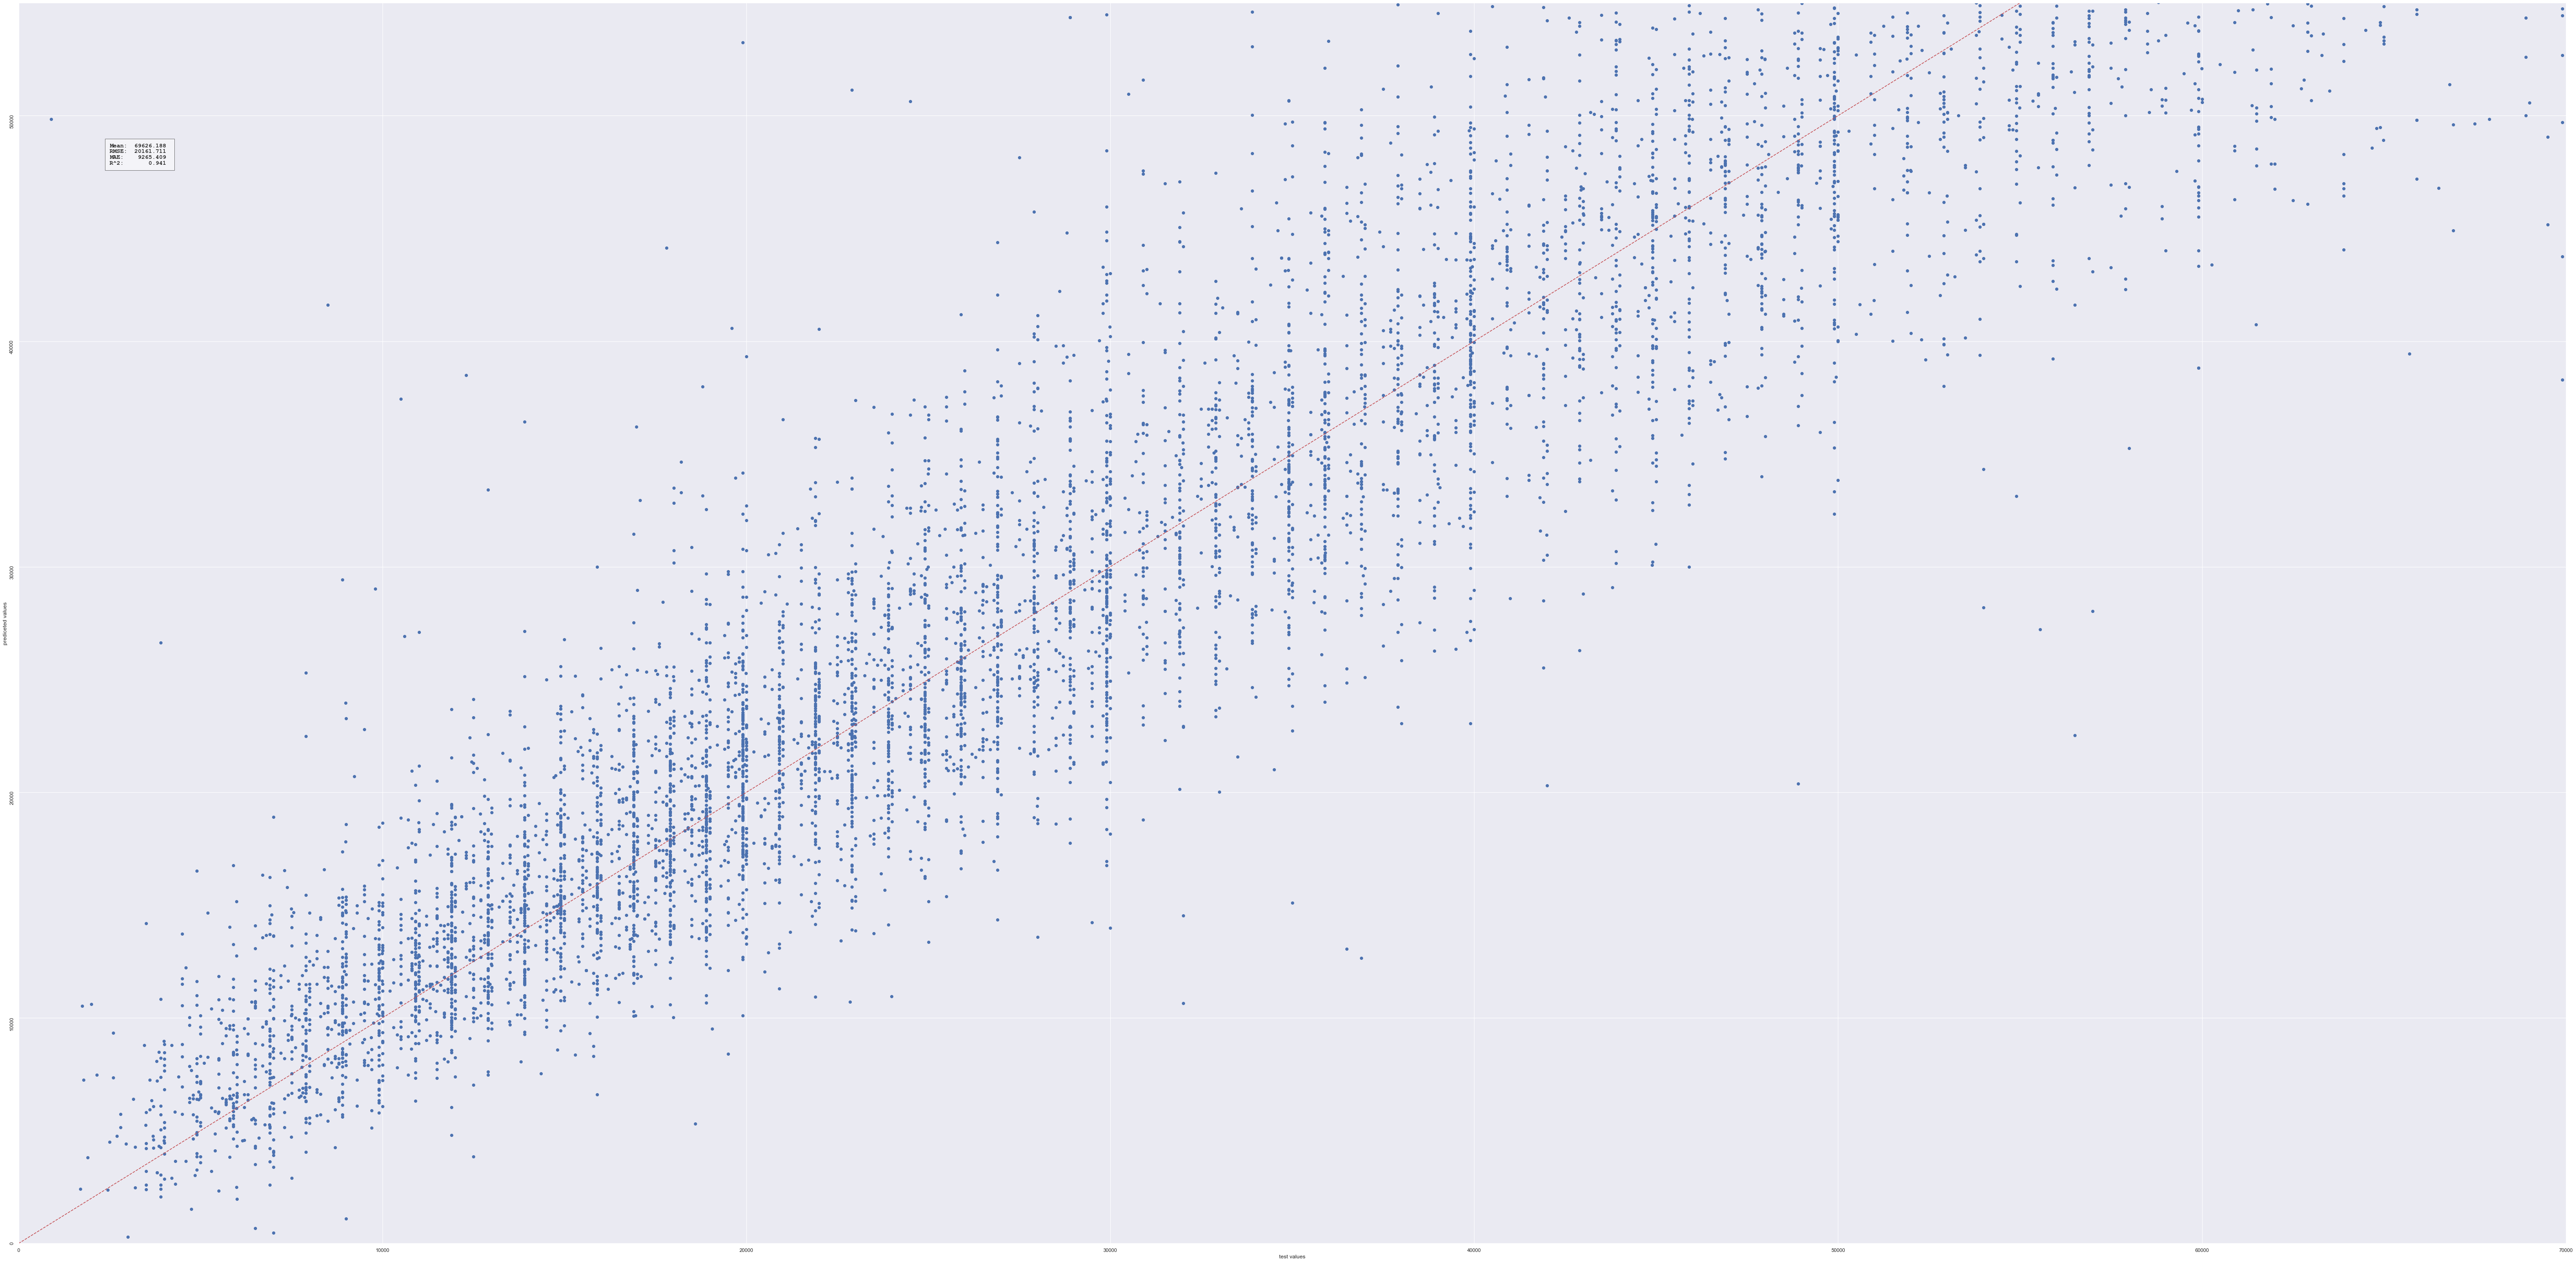

In [152]:
max = 55000
sns.set(rc={'figure.figsize':(100,50)})
plt.xlim(0,70000)
plt.ylim(0,max)
plt.scatter(y_test,y_pred)
plt.yticks(rotation="90")
plt.xlabel("test values")
plt.ylabel("prediceted values")
plt.plot([0,max],[0,max],'r--')
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
        #plt.title(str(title).upper(), font={'size':16})
t1, t2, t3, t4 = "Mean:", "RMSE:", "MAE:", "R^2:"
s1, s2, s3, s4 = format(y_pred.mean(),'.3f'), format(rmse,'.3f'), format(mae,'.3f'), format(r2,'.3f')
plt.annotate(f"{t1} {s1:>10} \n{t2} {s2:>10} \n{t3} {s3:>11} \n{t4} {s4:>11}", [2500,max*.87],
                            font={'size':13, 'family':'courier new', 'weight':'bold'},
                            bbox={'facecolor': 'white', 'edgecolor' : 'black', 'alpha': 0.5, 'pad': 10})
plt.show()

Dobranie najlepszych hiperparametrów dla XGBRegressor()

In [153]:
#RANDOMIZEDSEARCHCV - 'dart','gbtree'
params={
    "learning_rate" : [0.15,0.20],
    "max_depth" : [4,8,12] ,
    "colsample_bytree" : [0.5,0.7],
    "n_estimators" : [100,150,170],
    'gamma' : [0.01,0.1],
    
}
boo=['dart','gbtree']
for boost in boo:
    model_x3=xgb.XGBRegressor(booster=boost)
    random_search=RandomizedSearchCV(model_x3, param_distributions=params,random_state=42)
    random_search.fit(X_train, y_train)
    y_pred=random_search.predict(X_test)
    print('Score R2 : ',boost,random_search.score(X_test,y_test))
    rmse=np.sqrt(mean_squared_error(y_test,y_pred))
    mae=mean_absolute_error(y_test,y_pred)
    print('RMSE : ',boost,rmse)
    print('MAE',boost, mae)
    print('best_params: ',random_search.best_params_)
    print("================")

Score R2 :  dart 0.944380731913918
RMSE :  dart 19520.505111518447
MAE dart 8690.110994433138
best_params:  {'n_estimators': 170, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 0.01, 'colsample_bytree': 0.7}
Score R2 :  gbtree 0.9449783989846164
RMSE :  gbtree 19415.34124580843
MAE gbtree 8131.805275191181
best_params:  {'n_estimators': 170, 'max_depth': 12, 'learning_rate': 0.15, 'gamma': 0.1, 'colsample_bytree': 0.7}


In [ ]:


#RANDOMIZEDSEARCHCV - 'dart','gbtree'
params={
    "max_depth" : [8,12,15] ,
    "n_estimators" : [150,250,300],
    "learning_rate" : [0.15,0.20],
    
}


model_x3=xgb.XGBRegressor(booster='dart',learning_rate = 0.1, gamma =0.01, colsample_bytree= 0.5)
random_search=RandomizedSearchCV(model_x3, param_distributions=params,random_state=42)
random_search.fit(X_train, y_train)
y_pred=random_search.predict(X_test)
print('Score R2 : ',random_search.score(X_test,y_test))
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
mae=mean_absolute_error(y_test,y_pred)
print('RMSE : ',rmse)
print('MAE', mae)
print('best_params: ',random_search.best_params_)
print("================")
l7.append([ rmse,'MAE :', mae,'best_params: ',random_search.best_params_, 'params_estimator',random_search.best_estimator_] )


In [83]:
print(l7)
random_search.score(X_test,y_test)

[[19685.736904124642, 'MAE :', 8748.993127058378, 'best_params: ', {'n_estimators': 90, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}, 'params_estimator', RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_split=10,
                      n_estimators=90)]]


0.9474678261288845

In [154]:
# GRIDSEARCHCV -'dart','gbtree' pusc
params={
    "learning_rate" : [0.15,0.20],
    "max_depth" : [4,8,12] ,
    "colsample_bytree" : [0.5,0.7],
    "n_estimators" : [100,150,170],
    'gamma' : [0.01,0.1],


}
boo=['dart','gbtree']
l2=[]
for boost in boo:
    model_x3=xgb.XGBRegressor(booster=boost)
    gs=GridSearchCV(estimator=model_x3,
                param_grid=params,
                scoring=["r2","neg_root_mean_squared_error"],
                refit="r2",
                cv=5,n_jobs=6,
                verbose=4)

    gs.fit(X_train,y_train)
    y_predgs=gs.predict(X_test)
    gs.score(X_train,y_train)
    gs.score(X_test,y_test)
    r2 = r2_score(y_test, y_predgs)
    score=gs.score(X_test,y_test)
    rmse=np.sqrt(mean_squared_error(y_test,y_predgs))
    mae=mean_absolute_error(y_test,y_predgs)
    print('================================')
    print('Score : ', score)
    print('r2:  ', r2)
    print('RMSE:  ', rmse)
    print('MAE', mae)
    print('best_params: ',gs.best_params_)
    print('================================')
    l2.append([boost,'Score : ', score,'r2:  ', r2,'RMSE :  ', rmse,'MAE :', mae,'best_params: ',gs.best_params_, 'param_estimator',gs.best_estimator_])
    print(l2)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Score :  0.944380731913918
r2:   0.944380731913918
RMSE:   19520.505111518447
MAE 8690.110994433138
best_params:  {'colsample_bytree': 0.7, 'gamma': 0.01, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 170}
[['dart', 'Score : ', 0.944380731913918, 'r2:  ', 0.944380731913918, 'RMSE :  ', 19520.505111518447, 'MAE :', 8690.110994433138, 'best_params: ', {'colsample_bytree': 0.7, 'gamma': 0.01, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 170}, 'param_estimator', XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0.01, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=170, n_jobs=8,
             num_parallel_tree=1, predictor='aut

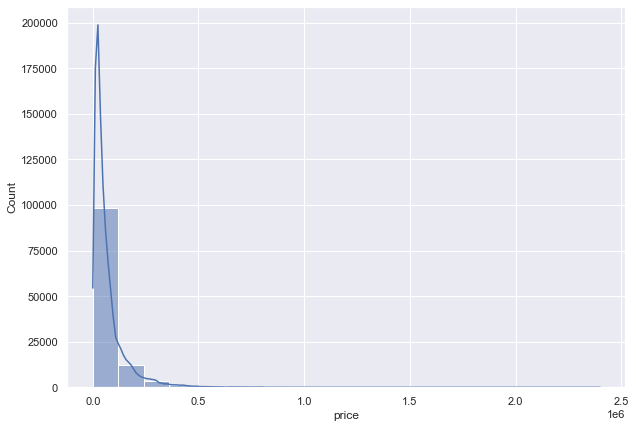

In [160]:
def price():
    rcParams['figure.figsize'] = 10, 7
    sns.histplot(data['price'], bins=20,kde=True)
 #   _ = plt.title("Histogram rozkładu Ceny")
price()

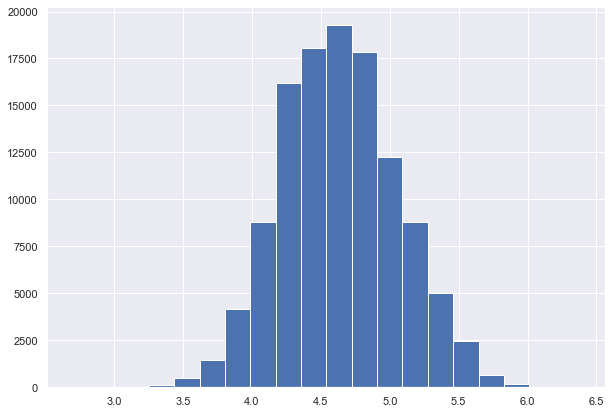

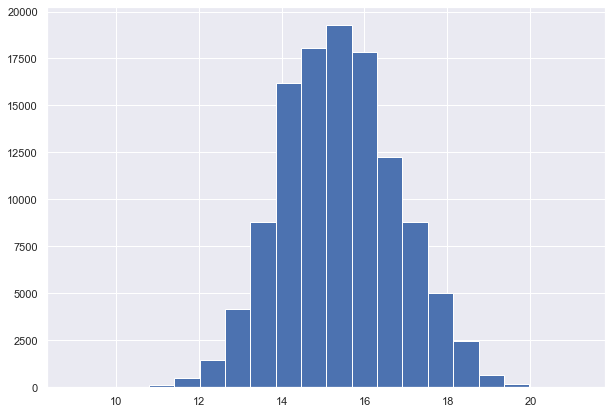

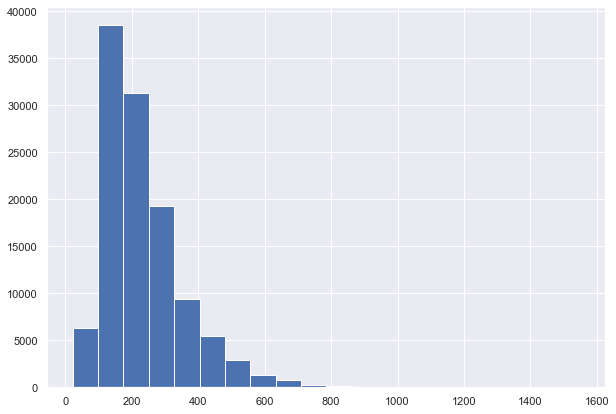

In [157]:
def hist_price():
    nums={'log10': np.log10, 'log2': np.log2,'sqrt': np.sqrt}
    for key , value in nums.items():
        a="Histogram rozkładu Ceny "+str(key)
        plt.hist(value(data['price']), bins=20)
       # _ = plt.title(a, size=20)
        plt.show()
hist_price()

In [158]:
#log10
y_train_log=np.log10(y_train)
model_v1=xgb.XGBRegressor()
model_v1.fit(X_train,y_train_log)
y_pred_log=model_v1.predict(X_test)
y_pred_log=10**y_pred_log
r2 = r2_score(y_test, y_pred_log)
score=model_v1.score(X_test,y_test)
rmse=np.sqrt(mean_squared_error(y_test,y_pred_log))
mae=mean_absolute_error(y_test,y_pred_log)
print('Score : ', score)
print('r2', r2)
print('RMSE:  ', rmse)
print('MAE', mae)

Score :  -0.707222227384348
r2 0.9370839908000099
RMSE:   20761.513023233907
MAE 9251.079800506686


In [159]:
y_train_sqrt=np.sqrt(y_train)

model_v2=xgb.XGBRegressor()
model_v2.fit(X_train,y_train_sqrt)
y_pred_sqrt=model_v2.predict(X_test)
y_pred_sqrt=y_pred_sqrt**2
score=model_v2.score(X_test,y_test)
rmse=np.sqrt(mean_squared_error(y_test,y_pred_sqrt))
mae=mean_absolute_error(y_test,y_pred_sqrt)
r2 = r2_score(y_test, y_pred_sqrt)
print('r2', r2)
print('Score : ', score)
print('RMSE:  ', rmse)
print('MAE', mae)

r2 0.9408395970298368
Score :  -0.6999215828821777
RMSE:   20132.32711261048
MAE 9044.190802956351


In [94]:
#grind sqrt
params={
    "learning_rate" : [0.05,0.10,0.15,],
    "max_depth" : [3,4,,6,8] ,
    "colsample_bytree" : [0.5,0.7],
    "n_estimators" : [7,15,30,50,70,100,150],
    'gamma' : [0.01,0.1]
    
}
boo=['dart','gbtree']
l=[]
y_train_sqrt=np.sqrt(y_train)
for boost in boo:
    y_train_sqrt=np.sqrt(y_train)
    model_x3=xgb.XGBRegressor(booster=boost)
    gs=GridSearchCV(estimator=model_x3,
                param_grid=params,
                scoring=["r2","neg_root_mean_squared_error"],
                refit="r2",
                cv=5, n_jobs=8,
                verbose=4)

    gs.fit(X_train,y_train_sqrt)
    y_predgs_sqrt=gs.predict(X_test)
    y_predgs=y_predgs_sqrt**2
    gs.score(X_train,y_train)
    gs.score(X_test,y_test)
    score=gs.score(X_test,y_test)
    rmse=np.sqrt(mean_squared_error(y_test,y_predgs))
    mae=mean_absolute_error(y_test,y_predgs)
    print('================================')
    print('Score : ', score)
    print('RMSE:  ', rmse)
    print('MAE', mae)
    print('best_params: ',gs.best_params_)
    print('================================')
    l.append([boost,'Score : ', score,'RMSE :  ', rmse,'MAE :', mae,'best_params: ',gs.best_params_, 'params_estimator',gs.best_estimator_] )
    print(l)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
Score :  -0.6745637301153848
RMSE:   22020.589135615213
MAE 8416.717317292305
best_params:  {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.15, 'max_depth': 8, 'n_estimators': 150}
[['dart', 'Score : ', -0.6745637301153848, 'RMSE :  ', 22020.589135615213, 'MAE :', 8416.717317292305, 'best_params: ', {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.15, 'max_depth': 8, 'n_estimators': 150}, 'params_estimator', XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0.1, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.15, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=150, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
            

In [96]:
#grind sqrt
params={
    "learning_rate" : [0.05,0.10,0.15,],
    "max_depth" : [3,4,6,8] ,
    "colsample_bytree" : [0.5,0.7],
    "n_estimators" : [150,200,250],
    'gamma' : [0.01,0.1]
    
}
boo=['dart','gbtree']
l1=[]
y_train_sqrt=np.sqrt(y_train)
for boost in boo:
    y_train_sqrt=np.sqrt(y_train)
    model_x3=xgb.XGBRegressor(booster=boost)
    gs=GridSearchCV(estimator=model_x3,
                param_grid=params,
                scoring=["r2","neg_root_mean_squared_error"],
                refit="r2",
                cv=5, n_jobs=8,
                verbose=4)

    gs.fit(X_train,y_train_sqrt)
    y_predgs_sqrt=gs.predict(X_test)
    y_predgs=y_predgs_sqrt**2
    gs.score(X_train,y_train)
    gs.score(X_test,y_test)
    score=gs.score(X_test,y_test)
    rmse=np.sqrt(mean_squared_error(y_test,y_predgs))
    mae=mean_absolute_error(y_test,y_predgs)
    print('================================')
    print('Score : ', score)
    print('RMSE:  ', rmse)
    print('MAE', mae)
    print('best_params: ',gs.best_params_)
    print('================================')
    l1.append([boost,'Score : ', score,'RMSE :  ', rmse,'MAE :', mae,'best_params: ',gs.best_params_, 'params_estimator',gs.best_estimator_] )
    print(l1)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Score :  -0.6745544486356667
RMSE:   21927.215905597182
MAE 8165.199326407907
best_params:  {'colsample_bytree': 0.7, 'gamma': 0.01, 'learning_rate': 0.15, 'max_depth': 8, 'n_estimators': 250}
[['dart', 'Score : ', -0.6745544486356667, 'RMSE :  ', 21927.215905597182, 'MAE :', 8165.199326407907, 'best_params: ', {'colsample_bytree': 0.7, 'gamma': 0.01, 'learning_rate': 0.15, 'max_depth': 8, 'n_estimators': 250}, 'params_estimator', XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0.01, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.15, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=250, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
          

Model Końcowy XGBRegressor

In [14]:
model_x2=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0.01, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.15, max_delta_step=0,
             max_depth=12, min_child_weight=1,
             monotone_constraints='()', n_estimators=150, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
model_x2.fit(X_train,y_train)
y_pred=model_x2.predict(X_test)
print("wyniki medelu XGBRegressor() :")
print('Score R2 : ',model_x2.score(X_test,y_test))
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
mae=mean_absolute_error(y_test,y_pred)
print('RMSE : ',rmse)
print('MAE', mae)


wyniki medelu XGBRegressor() :
Score R2 :  0.9450386885373115
RMSE :  19404.701214922487
MAE 8136.591895361872


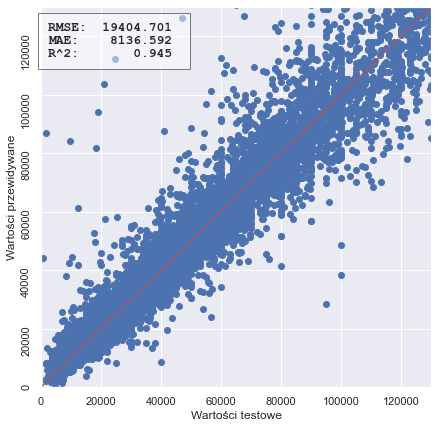

In [190]:
max = 130000

sns.set(rc={'figure.figsize':(7,7)})
plt.xlim(0,130000)
plt.ylim(0,max)
plt.scatter(y_test,y_pred)
plt.yticks(rotation="90")
plt.xlabel("Wartości testowe")
plt.ylabel("Wartości przewidywane")
plt.plot([0,max],[0,max],'r--')

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
                #plt.title(str(title).upper(), font={'size':16})
t1, t2, t3, t4 = "Mean:", "RMSE:", "MAE:", "R^2:"
s1, s2, s3, s4 = format(y_pred.mean(),'.3f'), format(rmse,'.3f'), format(mae,'.3f'), format(r2,'.3f')
plt.annotate(f"{t2} {s2:>10} \n{t3} {s3:>11} \n{t4} {s4:>11}", [2500,max*.87],
                                font={'size':13, 'family':'courier new', 'weight':'bold'},
                                bbox={'facecolor': 'white', 'edgecolor' : 'black', 'alpha': 0.5, 'pad': 10})
     
plt.show()

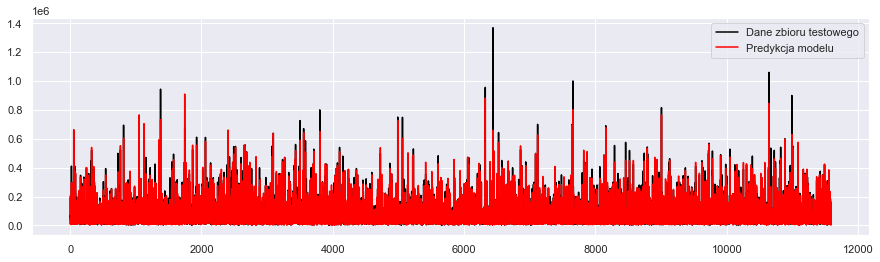

In [189]:
plt.figure(figsize=(15,4))
    

plt.plot(np.arange(len(y_test)), y_test, color='black', label='Dane zbioru testowego')
plt.plot(np.arange(len(y_pred)), y_pred, color='red' ,label='Predykcja modelu')
plt.legend()
plt.show()

In [15]:
model_x2.save_model("model_pred_car.json")